In [29]:
# Data processing
import numpy as np
import pandas as pd
import xarray as xr
import iris
import iris.pandas
import warnings
warnings.filterwarnings('ignore', module='iris')
from pathlib import Path
import dateutil.parser
from datetime import datetime, timedelta
# Visualization
import cartopy.util
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
# Scientific parameters
M_air = 28.97 # molar mass of dry air [g mol-1]
# Coefficients to convert mass mixing ratio to volume mixing ratio
coeff_c2h6 = (M_air/30.0690)*1e12 # Ethane_WAS
coeff_c3h8 = (M_air/44.0956)*1e12 # Propane_WAS
coeff_nc4h10 = (M_air/58.1222)*1e12 # n-Butane_WAS
coeff_ic4h10 = (M_air/58.1222)*1e12 # i-Butane_WAS
coeff_nc5h12 = (M_air/72.1488)*1e12 # n-Pentane_WAS
coeff_ic5h12 = (M_air/72.1488)*1e12 # i-Pentane_WAS
coeff_meono2 = (M_air/77.0394)*1e12 # MeONO2_WAS
coeff_sbuono2 = (M_air/119.1192)*1e12 # 2-BuONO2_WAS or sBuONO2
coeff_n2peono2 = (M_air/133.1457)*1e12 # 2-PenONO2_WAS or n2PeONO2 or nPeBONO2
coeff_n3peono2 = (M_air/133.1457)*1e12 # 3-PenONO2_WAS or n3PeONO2 or nPeCONO2
coeff_ipeono2 = (M_air/133.1457)*1e12 # 3-Methyl-2-BuONO2_WAS or iPeONO2 or iPeBONO2
# Plotting parameters
plt.rcParams['mathtext.default'] = 'regular'
def m2km(x, pos):
    '''Convert meters to kilometers when plotting axis labels'''
    return int(x*1e-3) #'{:1.1f}'.format(x*1e-3)
savefig = False
# Species names
str_c2h6 = '$C_2H_6$'; str_c3h8 = '$C_3H_8$'
str_nc4h10 = '$nC_4H_{10}$'; str_ic4h10 = '$iC_4H_{10}$'
str_nc5h12 = '$nC_5H_{12}$'; str_ic5h12 = '$iC_5H_{12}$'
str_meono2 = '$MeONO_2$'; str_sbuono2 = '2-$BuONO_2$'
str_n2peono2 = '2-$PenONO_2$'; str_n3peono2 = '3-$PenONO_2$'; str_ipeono2 = '3-Methyl-2-$BuONO_2$'

#### Read data

In [4]:
path_to_atom = Path('../../../../../../obs/ATom/nc/data')
# Select flight
fname_atom_flight = 'MER-WAS_DC8_20160729_R14.nc'
# Read ATom data
atom_dsinf = xr.open_dataset(path_to_atom / fname_atom_flight, decode_times=True)
atom_dsmms = xr.open_dataset(path_to_atom / fname_atom_flight, group='MMS', decode_cf=True)
atom_dswas = xr.open_dataset(path_to_atom / fname_atom_flight, group='WAS', decode_cf=True)

In [6]:
# Read precalculated UKCA trajectories
ukca_run_name = 'az166a'
compared_common_id = '160729_160729_1607_singl'
path_to_prcd = Path('../../../../processed') / ukca_run_name
traj_c2h6 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_c2h6.nc')
traj_c3h8 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_c3h8.nc')
traj_nc4h10 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_nc4h10.nc')
traj_ic4h10 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_ic4h10.nc')
traj_nc5h12 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_nc5h12.nc')
traj_ic5h12 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_ic5h12.nc')
traj_meono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_meono2.nc')
traj_sbuono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_sbuono2.nc')
traj_n2peono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_n2peono2.nc')
traj_n3peono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_n3peono2.nc')
traj_ipeono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_ipeono2.nc')

In [8]:
# Path to figures
path_to_figs = Path('../../../../../../results') / ukca_run_name / compared_common_id
path_to_figs.mkdir(exist_ok=True) # create a new folder if it doesn't exist
print(compared_common_id)

160729_160729_1607_singl


#### Time series along a flight track

In [9]:
# Extract datetimes from ATom and UKCA output
# ICARTT docs: 'Time is to be reported as seconds UTC from the start of the date on which measurements began. 
#               This date appears in both the file header and filename.'
t_yr = int(str(atom_dsinf.Flight_ID.values).split('_')[1][0:4])
t_mn = int(str(atom_dsinf.Flight_ID.values).split('_')[1][4:6])
t_da = int(str(atom_dsinf.Flight_ID.values).split('_')[1][6:8])
times = []
for i in atom_dsinf.UTC_Mid_WAS.values:
    times.append(datetime(t_yr,t_mn,t_da,hour=0,minute=0,second=0) + timedelta(seconds=i))
atom_date_start = atom_dsinf.time[0].values.astype('<M8[us]').astype(datetime)
ukca_days_since = dateutil.parser.parse(str(traj_c2h6.coord('time').units)[12::])
ukca_date = ukca_days_since + timedelta(hours=traj_c2h6.coord('time').points.tolist()[0])

In [77]:
# Convert ATom C2H6, C2H4, C2H2, C3H8, C3H6 to pptvC to match UKCA lumped species, namely C2H6=C2H6+C2H4+C2H2, C3H8=C3H8+C3H6
atom_dswas_c2h6 = atom_dswas['Ethane_WAS']*2 + atom_dswas['Ethene_WAS']*2 + atom_dswas['Ethyne_WAS']*2
atom_dswas_c3h8 = atom_dswas['Propane_WAS']*3 + atom_dswas['Propene_WAS']*3
# Select model data where obs are present
traj_c2h6_ifobsexist = np.where(~np.isnan(atom_dswas_c2h6), traj_c2h6.data, atom_dswas_c2h6)
traj_c3h8_ifobsexist = np.where(~np.isnan(atom_dswas_c3h8), traj_c3h8.data, atom_dswas_c3h8)
traj_nc4h10_ifobsexist = np.where(~np.isnan(atom_dswas['n-Butane_WAS']), traj_nc4h10.data, atom_dswas['n-Butane_WAS'])
traj_ic4h10_ifobsexist = np.where(~np.isnan(atom_dswas['i-Butane_WAS']), traj_ic4h10.data, atom_dswas['i-Butane_WAS'])
traj_nc5h12_ifobsexist = np.where(~np.isnan(atom_dswas['n-Pentane_WAS']), traj_nc5h12.data, atom_dswas['n-Pentane_WAS'])
traj_ic5h12_ifobsexist = np.where(~np.isnan(atom_dswas['i-Pentane_WAS']), traj_ic5h12.data, atom_dswas['i-Pentane_WAS'])
traj_meono2_ifobsexist = np.where(~np.isnan(atom_dswas['MeONO2_WAS']), traj_meono2.data, atom_dswas['MeONO2_WAS'])
traj_sbuono2_ifobsexist = np.where(~np.isnan(atom_dswas['2-BuONO2_WAS']), traj_sbuono2.data, atom_dswas['2-BuONO2_WAS'])
traj_n2peono2_ifobsexist = np.where(~np.isnan(atom_dswas['2-PenONO2_WAS']), traj_n2peono2.data, atom_dswas['2-PenONO2_WAS'])
traj_n3peono2_ifobsexist = np.where(~np.isnan(atom_dswas['3-PenONO2_WAS']), traj_n3peono2.data, atom_dswas['3-PenONO2_WAS'])
traj_ipeono2_ifobsexist = np.where(~np.isnan(atom_dswas['3-Methyl-2-BuONO2_WAS']), traj_ipeono2.data, atom_dswas['3-Methyl-2-BuONO2_WAS'])

In [60]:
# Time series plotting parameters
def plot_ts(atom, ukca, species, ppn, picname):
    '''Plot observed and modelled species time series along a flight track (flight altitude is on the secondary y axis).'''
    fig, ax = plt.subplots(figsize=(12,4), facecolor='w')
    ax.plot(times, atom, color='k')
    ax.plot(times, ukca, color='r')
    ax2 = ax.twinx()
    ax2.plot(times, atom_dsmms.G_ALT, color='grey', linestyle='--', alpha=0.5)
    # common
    ax.set_title(species)
    ax.set_title(f'{atom_date_start.strftime("%d %B %Y")}', loc='left')
    ax.set_xlabel('Time, hours (UTC)')
    ax.set_ylabel(ppn)
    ax.set_xticklabels(times)
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
    ax.margins(x=0)
    ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
    ax2.yaxis.set_major_formatter(FuncFormatter(m2km))
    ax2.set_ylabel('Altitude, km', color='grey')
    ax2.tick_params('y', colors='grey')
    if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_{picname}.png', bbox_inches='tight')

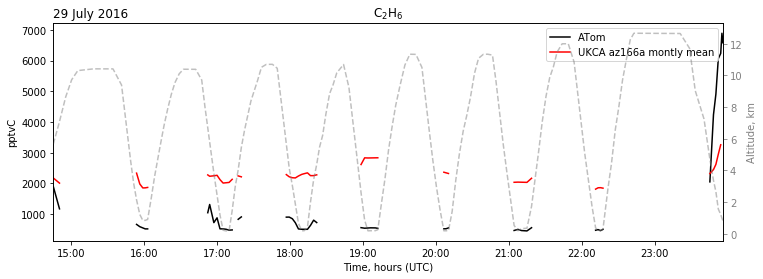

In [61]:
plot_ts(atom_dswas_c2h6, traj_c2h6_ifobsexist*2, str_c2h6, 'pptvC', 'ts_RH_C2')

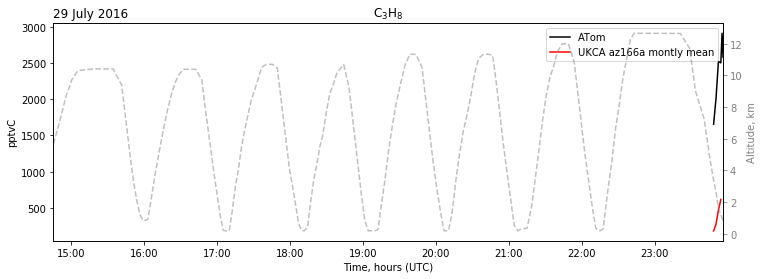

In [62]:
plot_ts(atom_dswas_c3h8, traj_c3h8_ifobsexist*3, str_c3h8, 'pptvC', 'ts_RH_C3')

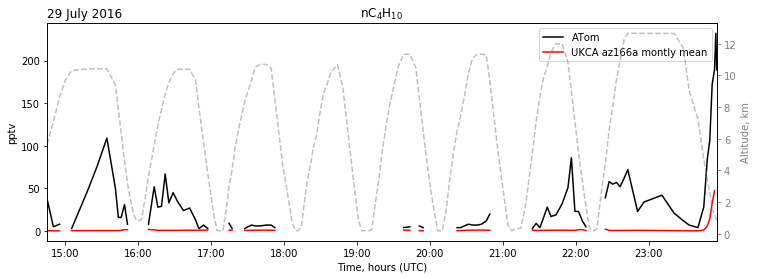

In [63]:
plot_ts(atom_dswas['n-Butane_WAS'], traj_nc4h10_ifobsexist, str_nc4h10, 'pptv', 'ts_RH_C4n')

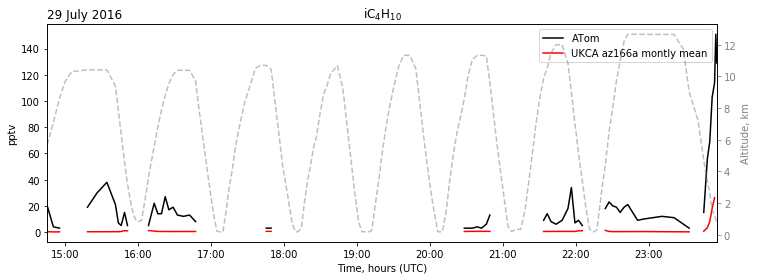

In [64]:
plot_ts(atom_dswas['i-Butane_WAS'], traj_ic4h10_ifobsexist, str_ic4h10, 'pptv', 'ts_RH_C4i')

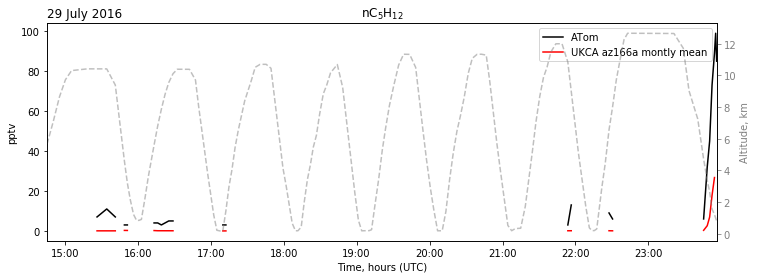

In [66]:
plot_ts(atom_dswas['n-Pentane_WAS'], traj_nc5h12_ifobsexist, str_nc5h12, 'pptv', 'ts_RH_C5n')

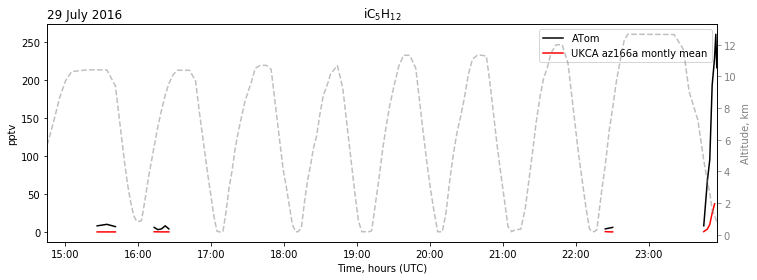

In [68]:
plot_ts(atom_dswas['i-Pentane_WAS'], traj_ic5h12_ifobsexist, str_ic5h12, 'pptv', 'ts_RH_C5i')

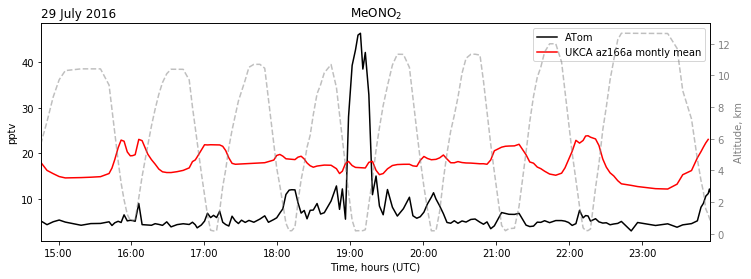

In [70]:
plot_ts(atom_dswas['MeONO2_WAS'], traj_meono2_ifobsexist, str_meono2, 'pptv', 'ts_RONO2_C1')

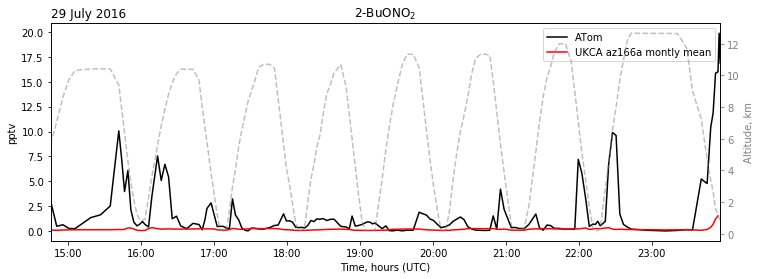

In [72]:
plot_ts(atom_dswas['2-BuONO2_WAS'], traj_sbuono2_ifobsexist, str_sbuono2, 'pptv', 'ts_RONO2_C4s')

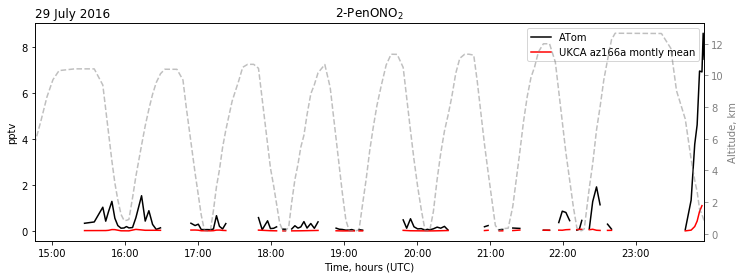

In [74]:
plot_ts(atom_dswas['2-PenONO2_WAS'], traj_n2peono2_ifobsexist, str_n2peono2, 'pptv', 'ts_RONO2_C5n2')

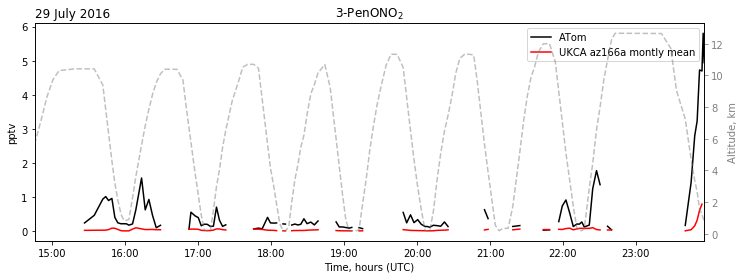

In [76]:
plot_ts(atom_dswas['3-PenONO2_WAS'], traj_n3peono2_ifobsexist, str_n3peono2, 'pptv', 'ts_RONO2_C5n3')

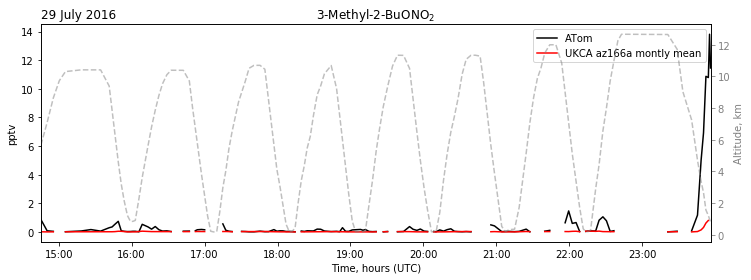

In [78]:
plot_ts(atom_dswas['3-Methyl-2-BuONO2_WAS'], traj_ipeono2_ifobsexist, str_ipeono2, 'pptv', 'ts_RONO2_C5i')

#### Cross section along a flight track

In [79]:
# Read precalculated UKCA 2D trajectories
crsc_c2h6 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_c2h6.nc')
crsc_c3h8 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_c3h8.nc')
crsc_nc4h10 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_nc4h10.nc')
crsc_ic4h10 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_ic4h10.nc')
crsc_nc5h12 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_nc5h12.nc')
crsc_ic5h12 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_ic5h12.nc')
crsc_meono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_meono2.nc')
crsc_sbuono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_sbuono2.nc')
crsc_n2peono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_n2peono2.nc')
crsc_n3peono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_n3peono2.nc')
crsc_ipeono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_ipeono2.nc')

In [80]:
# Convert xarray dataset with observational data to pandas dataframe
atom_c2h6 = atom_dswas_c2h6.to_dataframe(name='Lumped_C2H6_C2H4_C2H2')
atom_c3h8 = atom_dswas_c3h8.to_dataframe(name='Lumped_C3H8_C3H6')
atom_nc4h10 = atom_dswas['n-Butane_WAS'].to_dataframe()
atom_ic4h10 = atom_dswas['i-Butane_WAS'].to_dataframe()
atom_nc5h12 = atom_dswas['n-Pentane_WAS'].to_dataframe()
atom_ic5h12 = atom_dswas['i-Pentane_WAS'].to_dataframe()
atom_meono2 = atom_dswas['MeONO2_WAS'].to_dataframe()
atom_sbuono2 = atom_dswas['2-BuONO2_WAS'].to_dataframe()
atom_n2peono2 = atom_dswas['2-PenONO2_WAS'].to_dataframe()
atom_n3peono2 = atom_dswas['3-PenONO2_WAS'].to_dataframe()
atom_ipeono2 = atom_dswas['3-Methyl-2-BuONO2_WAS'].to_dataframe()

In [81]:
# Find max between maxima and max between minima in ATom and model cross section data for plotting a cross section with two colormaps
cs_c2h6_max = max(np.nanmax(atom_c2h6.values), np.nanmax(crsc_c2h6.data*2))
cs_c3h8_max = max(np.nanmax(atom_c3h8.values), np.nanmax(crsc_c3h8.data*3))
cs_nc4h10_max = max(np.nanmax(atom_nc4h10.values), np.nanmax(crsc_nc4h10.data))
cs_ic4h10_max = max(np.nanmax(atom_ic4h10.values), np.nanmax(crsc_ic4h10.data))
cs_nc5h12_max = max(np.nanmax(atom_nc5h12.values), np.nanmax(crsc_nc5h12.data))
cs_ic5h12_max = max(np.nanmax(atom_ic5h12.values), np.nanmax(crsc_ic5h12.data))
cs_meono2_max = max(np.nanmax(atom_meono2.values), np.nanmax(crsc_meono2.data))
cs_sbuono2_max = max(np.nanmax(atom_sbuono2.values), np.nanmax(crsc_sbuono2.data))
cs_n2peono2_max = max(np.nanmax(atom_n2peono2.values), np.nanmax(crsc_n2peono2.data))
cs_n3peono2_max = max(np.nanmax(atom_n3peono2.values), np.nanmax(crsc_n3peono2.data))
cs_ipeono2_max = max(np.nanmax(atom_ipeono2.values), np.nanmax(crsc_ipeono2.data))

cs_c2h6_min = min(np.nanmax(atom_c2h6.values), np.nanmax(crsc_c2h6.data*2))
cs_c3h8_min = min(np.nanmax(atom_c3h8.values), np.nanmax(crsc_c3h8.data*3))
cs_nc4h10_min = min(np.nanmax(atom_nc4h10.values), np.nanmax(crsc_nc4h10.data))
cs_ic4h10_min = min(np.nanmax(atom_ic4h10.values), np.nanmax(crsc_ic4h10.data))
cs_nc5h12_min = min(np.nanmax(atom_nc5h12.values), np.nanmax(crsc_nc5h12.data))
cs_ic5h12_min = min(np.nanmax(atom_ic5h12.values), np.nanmax(crsc_ic5h12.data))
cs_meono2_min = min(np.nanmax(atom_meono2.values), np.nanmax(crsc_meono2.data))
cs_sbuono2_min = min(np.nanmax(atom_sbuono2.values), np.nanmax(crsc_sbuono2.data))
cs_n2peono2_min = min(np.nanmax(atom_n2peono2.values), np.nanmax(crsc_n2peono2.data))
cs_n3peono2_min = min(np.nanmax(atom_n3peono2.values), np.nanmax(crsc_n3peono2.data))
cs_ipeono2_min = min(np.nanmax(atom_ipeono2.values), np.nanmax(crsc_ipeono2.data))

In [82]:
# Cross section plotting parameters
class MidpointNormalize(colors.Normalize):
    '''Merge two colormaps: color concentrations present in obs and model using one colormap and obs higher than model using another colormap'''
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
colors_low = plt.cm.Blues(np.linspace(0,1,128))
colors_high = plt.cm.autumn_r(np.linspace(0,1,128))
colors_stack = np.vstack((colors_low, colors_high))
mrgd_cmap = colors.LinearSegmentedColormap.from_list('merged_cmap', colors_stack)
cs_pc_kwargs = dict(cmap=mrgd_cmap, vmin=0) # model data pcolormesh options
cs_sc_kwargs = dict(cmap=mrgd_cmap, vmin=0, edgecolors='k', linewidth=0.2) # obs data scatter options
def plot_cs(atom, ukca, species, ppn, picname, cs_min, cs_max):
    '''Plot a cross section along a flight track, modelled data as background and observed data as dots.'''
    fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
    p0 = ax.pcolormesh(times, crsc_c2h6.coord('altitude').points, ukca, norm=MidpointNormalize(midpoint=cs_min), vmax=cs_max, **cs_pc_kwargs)
    ax.scatter(times, atom_dsmms.G_ALT, c=atom.squeeze(), norm=MidpointNormalize(midpoint=cs_min), vmax=cs_max, **cs_sc_kwargs)
    fig.colorbar(p0, label=ppn)
    # common
    ax.set_title(species, loc='center')
    ax.set_title(f'{atom_date_start.strftime("%d %B %Y")}', loc='left')
    ax.set_title(f'ATom vs UKCA {ukca_run_name} montly mean', loc='right')
    ax.set_xlabel('Time, hours (UTC)')
    ax.set_ylabel('Altitude, km')
    ax.set_ylim(0,13500)
    ax.set_xticklabels(times)
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
    ax.yaxis.set_major_formatter(FuncFormatter(m2km))
    ax.margins(x=0)
    if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_{picname}.png', bbox_inches='tight')

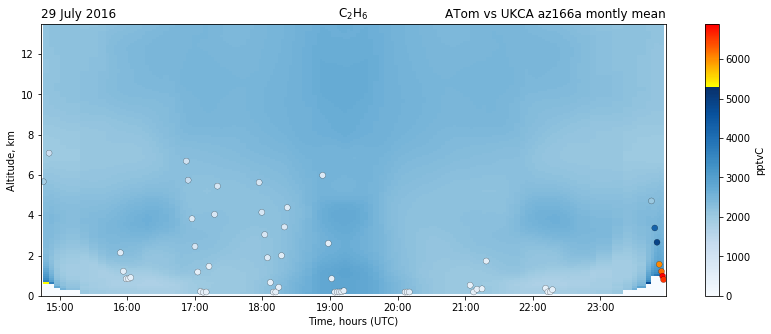

In [94]:
plot_cs(atom_c2h6, crsc_c2h6.data*2, str_c2h6, 'pptvC', 'cs_RH_C2', cs_c2h6_min, cs_c2h6_max)

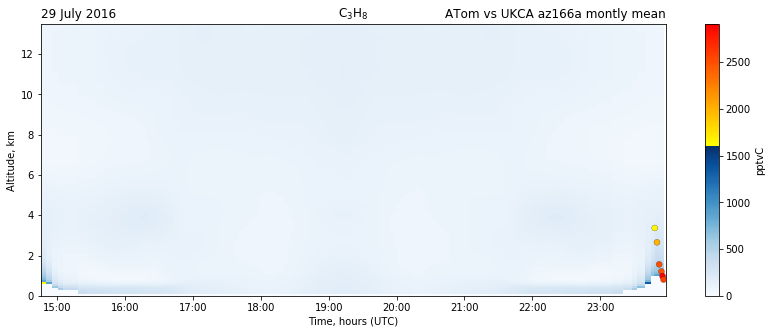

In [95]:
plot_cs(atom_c3h8, crsc_c3h8.data*3, str_c3h8, 'pptvC', 'cs_RH_C3', cs_c3h8_min, cs_c3h8_max)

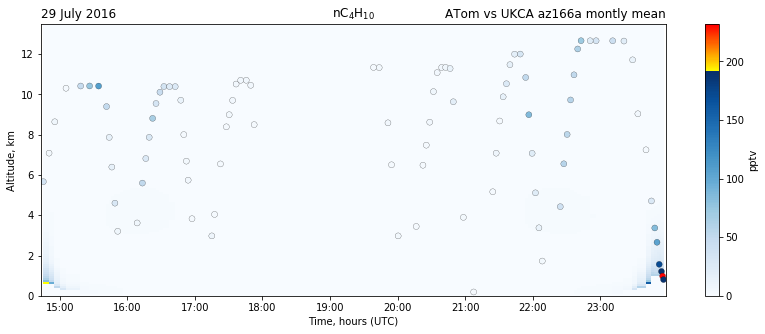

In [97]:
plot_cs(atom_nc4h10, crsc_nc4h10.data, str_nc4h10, 'pptv', 'cs_RH_C4n', cs_nc4h10_min, cs_nc4h10_max)

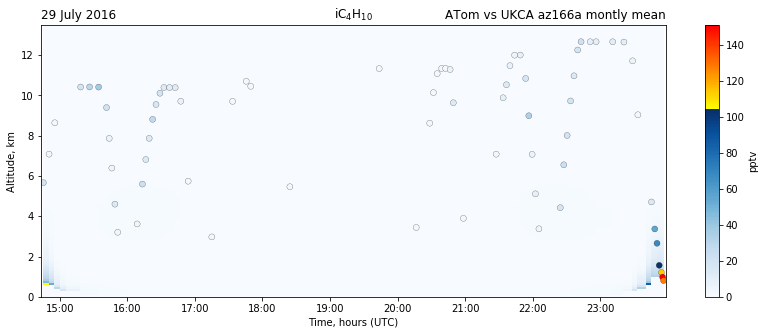

In [98]:
plot_cs(atom_ic4h10, crsc_ic4h10.data, str_ic4h10, 'pptv', 'cs_RH_C4i', cs_ic4h10_min, cs_ic4h10_max)

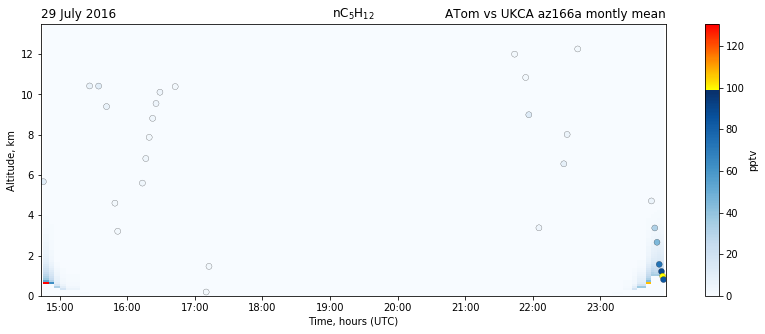

In [99]:
plot_cs(atom_nc5h12, crsc_nc5h12.data, str_nc5h12, 'pptv', 'cs_RH_C5n', cs_nc5h12_min, cs_nc5h12_max)

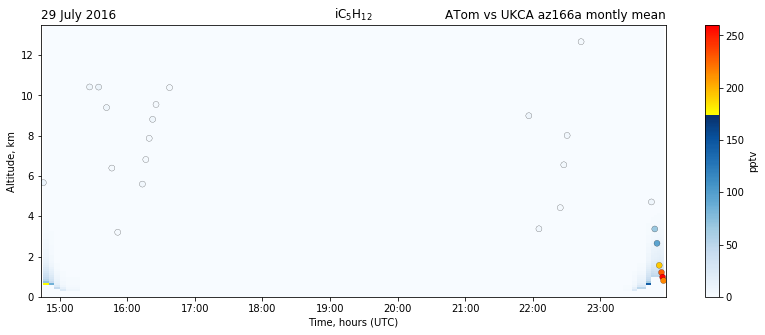

In [100]:
plot_cs(atom_ic5h12, crsc_ic5h12.data, str_ic5h12, 'pptv', 'cs_RH_C5i', cs_ic5h12_min, cs_ic5h12_max)

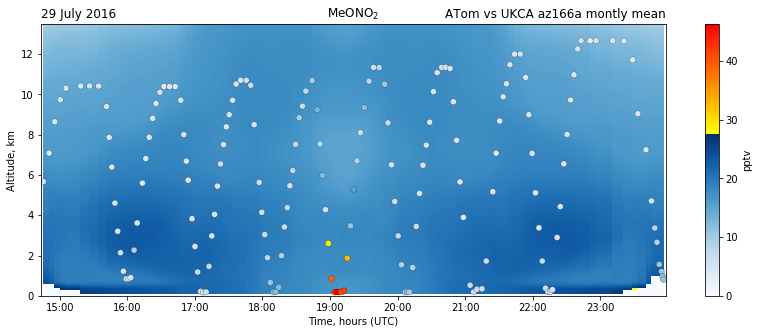

In [101]:
plot_cs(atom_meono2, crsc_meono2.data, str_meono2, 'pptv', 'cs_RONO2_C1', cs_meono2_min, cs_meono2_max)

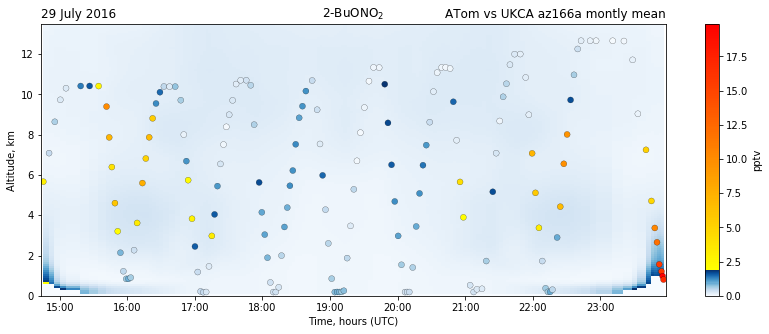

In [102]:
plot_cs(atom_sbuono2, crsc_sbuono2.data, str_sbuono2, 'pptv', 'cs_RONO2_C4s', cs_sbuono2_min, cs_sbuono2_max)

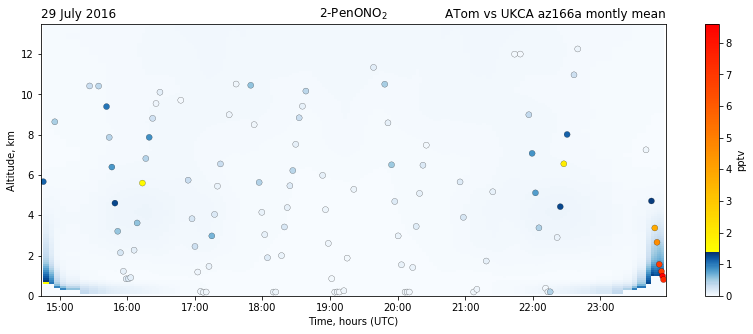

In [103]:
plot_cs(atom_n2peono2, crsc_n2peono2.data, str_n2peono2, 'pptv', 'cs_RONO2_C5n2', cs_n2peono2_min, cs_n2peono2_max)

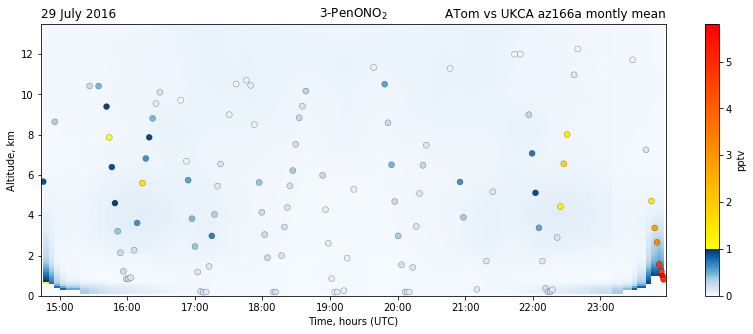

In [104]:
plot_cs(atom_n3peono2, crsc_n3peono2.data, str_n3peono2, 'pptv', 'cs_RONO2_C5n3', cs_n3peono2_min, cs_n3peono2_max)

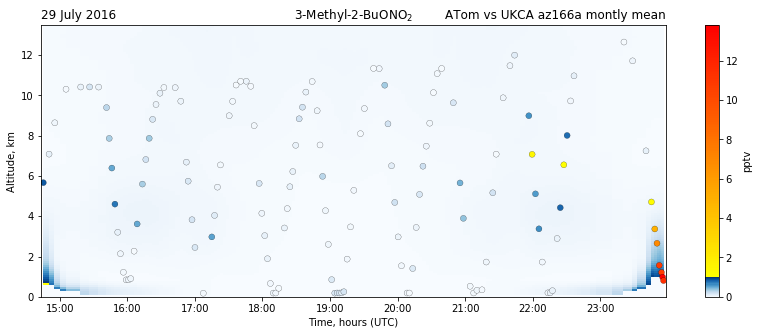

In [105]:
plot_cs(atom_ipeono2, crsc_ipeono2.data, str_ipeono2, 'pptv', 'cs_RONO2_C5i', cs_ipeono2_min, cs_ipeono2_max)

#### Scatter plot along a flight track

In [106]:
# Find max concentration between observational and model trajectory data
sct_max_c2h6 = max(np.nanmax(atom_c2h6.values), np.nanmax(traj_c2h6.data*2))
sct_max_c3h8 = max(np.nanmax(atom_c3h8.values), np.nanmax(traj_c3h8.data*3))
sct_max_nc4h10 = max(np.nanmax(atom_nc4h10.values), np.nanmax(traj_nc4h10.data))
sct_max_ic4h10 = max(np.nanmax(atom_ic4h10.values), np.nanmax(traj_ic4h10.data))
sct_max_nc5h12 = max(np.nanmax(atom_nc5h12.values), np.nanmax(traj_nc5h12.data))
sct_max_ic5h12 = max(np.nanmax(atom_ic5h12.values), np.nanmax(traj_ic5h12.data))
sct_max_meono2 = max(np.nanmax(atom_meono2.values), np.nanmax(traj_meono2.data))
sct_max_sbuono2 = max(np.nanmax(atom_sbuono2.values), np.nanmax(traj_sbuono2.data))
sct_max_n2peono2 = max(np.nanmax(atom_n2peono2.values), np.nanmax(traj_n2peono2.data))
sct_max_n3peono2 = max(np.nanmax(atom_n3peono2.values), np.nanmax(traj_n3peono2.data))
sct_max_ipeono2 = max(np.nanmax(atom_ipeono2.values), np.nanmax(traj_ipeono2.data))

In [125]:
def plot_one2one(atom, ukca, species, ppn, picname, sct_max):
    '''Plot all flight track data as a scatter plot.'''
    fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
    p0 = ax.scatter(atom, ukca, c=atom_dsmms.G_ALT)
    ax.plot([0, sct_max], [0, sct_max], color='k', linestyle='--') # 'one-to-one' line
    ax.set_title(f'{species}, {ppn}', loc='right')
    ax.set_title(f'{atom_date_start.strftime("%d %B %Y")}', loc='left')
    ax.set_xlabel('ATom')
    ax.set_ylabel(f'UKCA {ukca_run_name} montly mean')
    ax.set_xlim(0, sct_max)
    ax.set_ylim(0, sct_max)
    fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
    if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_{picname}.png', bbox_inches='tight')

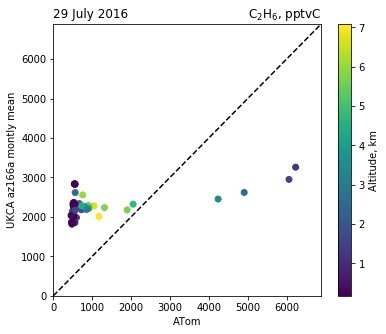

In [126]:
plot_one2one(atom_c2h6, traj_c2h6.data*2, str_c2h6, 'pptvC', '1to1_RH_C2', sct_max_c2h6)

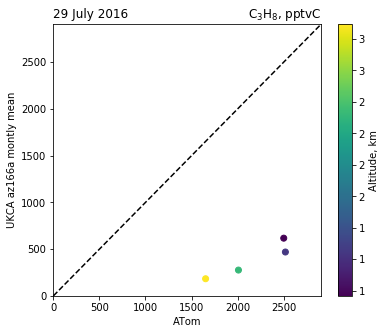

In [127]:
plot_one2one(atom_c3h8, traj_c3h8.data*3, str_c3h8, 'pptvC', '1to1_RH_C3', sct_max_c3h8)

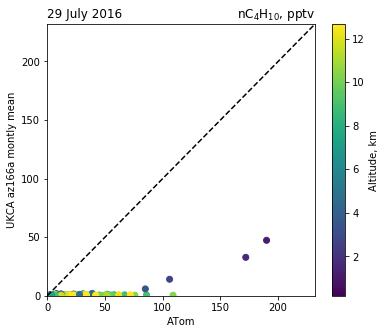

In [128]:
plot_one2one(atom_nc4h10, traj_nc4h10.data, str_nc4h10, 'pptv', '1to1_RH_C4n', sct_max_nc4h10)

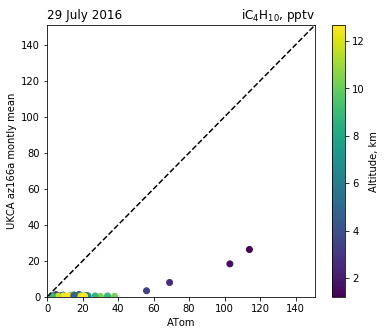

In [129]:
plot_one2one(atom_ic4h10, traj_ic4h10.data, str_ic4h10, 'pptv', '1to1_RH_C4i', sct_max_ic4h10)

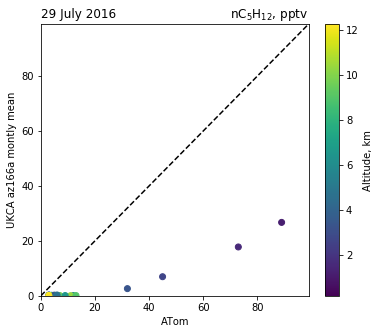

In [130]:
plot_one2one(atom_nc5h12, traj_nc5h12.data, str_nc5h12, 'pptv', '1to1_RH_C5n', sct_max_nc5h12)

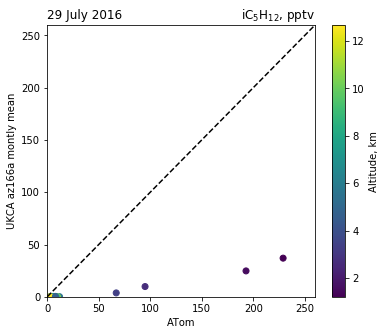

In [131]:
plot_one2one(atom_ic5h12, traj_ic5h12.data, str_ic5h12, 'pptv', '1to1_RH_C5i', sct_max_ic5h12)

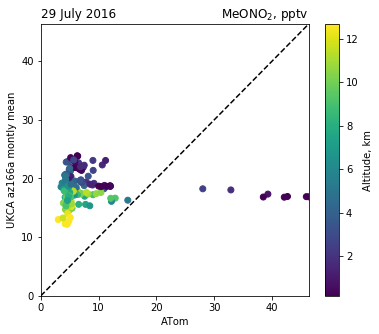

In [132]:
plot_one2one(atom_meono2, traj_meono2.data, str_meono2, 'pptv', '1to1_RONO2_C1', sct_max_meono2)

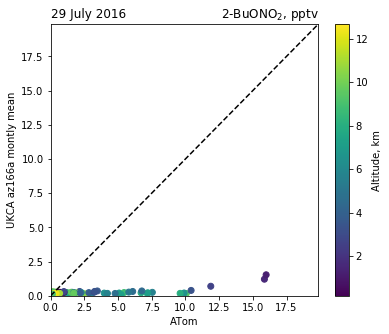

In [133]:
plot_one2one(atom_sbuono2, traj_sbuono2.data, str_sbuono2, 'pptv', '1to1_RONO2_C4s', sct_max_sbuono2)

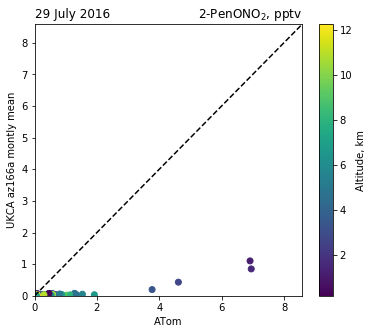

In [134]:
plot_one2one(atom_n2peono2, traj_n2peono2.data, str_n2peono2, 'pptv', '1to1_RONO2_C5n2', sct_max_n2peono2)

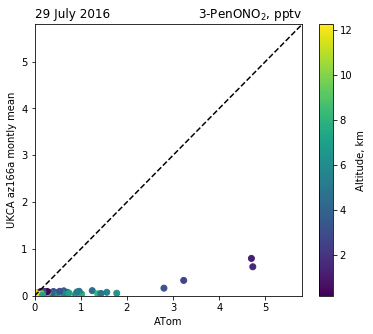

In [135]:
plot_one2one(atom_n3peono2, traj_n3peono2.data, str_n3peono2, 'pptv', '1to1_RONO2_C5n3', sct_max_n3peono2)

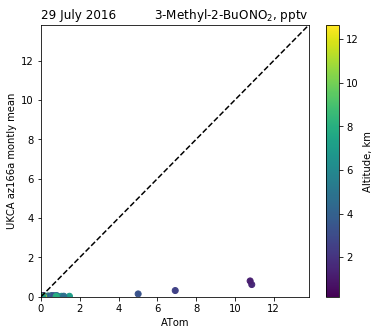

In [136]:
plot_one2one(atom_ipeono2, traj_ipeono2.data, str_ipeono2, 'pptv', '1to1_RONO2_C5i', sct_max_ipeono2)

#### Vertical profile along a flight track

In [177]:
# Choose bins
alt_bins = np.arange(0, 14000, 500)
alt_mod_bin_inds = np.arange(0, len(alt_bins), 1)
alt_obs_bin_inds = np.digitize(atom_dsmms.G_ALT.data, alt_bins)
# Bin observational data
obs_meono2_bin_mean = atom_meono2.groupby(alt_obs_bin_inds).mean().reindex(index=alt_mod_bin_inds, fill_value=np.nan)
obs_meono2_bin_min = atom_meono2.groupby(alt_obs_bin_inds).min().reindex(index=alt_mod_bin_inds, fill_value=np.nan)
obs_meono2_bin_max = atom_meono2.groupby(alt_obs_bin_inds).max().reindex(index=alt_mod_bin_inds, fill_value=np.nan)
# Convert iris cubes with model data to pandas dataframes
_ = traj_meono2.copy()
for coord in traj_meono2.coords():
    if coord.standard_name in ['time', 'longitude', 'latitude', 'surface_altitude', 'forecast_period', 'forecast_reference_time']:
        _.remove_coord(coord)
traj_pd_meono2 = iris.pandas.as_data_frame(_).T.squeeze()
# Bin model data
mod_meono2_bin_mean = traj_pd_meono2.groupby(alt_obs_bin_inds).mean().reindex(index=alt_mod_bin_inds, fill_value=np.nan).squeeze()
mod_meono2_bin_min = traj_pd_meono2.groupby(alt_obs_bin_inds).min().reindex(index=alt_mod_bin_inds, fill_value=np.nan).squeeze()
mod_meono2_bin_max = traj_pd_meono2.groupby(alt_obs_bin_inds).max().reindex(index=alt_mod_bin_inds, fill_value=np.nan).squeeze()

In [178]:
# Vertical profile plotting parameters
vp_barh_kwargs = dict(height=200, align='center', alpha=1)
def plot_vp(atom, ukca, species, ppn, picname, atom_min, atom_max, ukca_min, ukca_max):
    '''Plot vertical profile along a flight track.'''
    fig, ax = plt.subplots(figsize=(7,7), facecolor='w')
    ax.plot(atom, alt_bins, color='k')
    ax.barh(alt_bins, atom_max-atom_min, left=atom_min, color='k', **vp_barh_kwargs)
    ax.plot(ukca, alt_bins, color='r')
    ax.barh(alt_bins, ukca_max-ukca_min, left=ukca_min, color='r', **vp_barh_kwargs)
    # common
    ax.set_title(f'{species}, {ppn}', loc='right')
    ax.set_title(f'{atom_date_start.strftime("%d %B %Y")}', loc='left')
    ax.set_ylabel('Altitude, km')
    ax.set_ylim(-200,13500)
    ax.set_yticks(alt_bins)
    ax.set_yticklabels(map(int,(alt_bins/1000)))
    ax.legend(['ATom', f'UKCA {ukca_run_name} montly mean'])
    for ytcklbl in ax.yaxis.get_ticklabels()[1::2]:
        ytcklbl.set_visible(False)
    if savefig: fig.savefig(path_to_results / f'{ukca_run_name}_{atom_ukca_datetime_match}_{picname}.png', bbox_inches='tight')

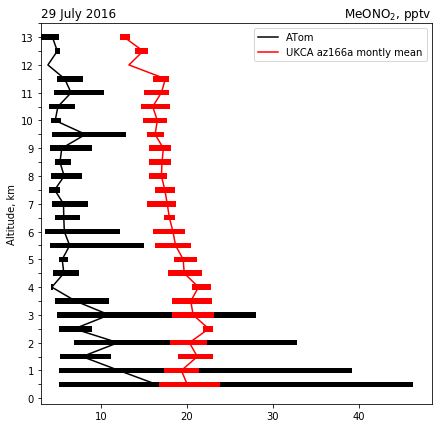

In [179]:
plot_vp(obs_meono2_bin_mean, mod_meono2_bin_mean, str_meono2, 'pptv', 'vp_RONO2_C1', 
        obs_meono2_bin_min.MeONO2_WAS, obs_meono2_bin_max.MeONO2_WAS, mod_meono2_bin_min, mod_meono2_bin_max)